## Make Figure 2 - example of classification on detections
- note: classification functions are at the bottom of the notebook

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

import numpy as np
import obspy
from obspy.clients.fdsn.client import Client 

import obspy
import scipy

import pandas as pd

client = Client('IRIS')

import matplotlib
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]
matplotlib.rcParams.update({'font.size':14})

In [12]:
tphase_time = [obspy.UTCDateTime('2019-04-22T23:25:59.763862Z'),obspy.UTCDateTime('2019-04-22T23:30:29.795115Z')]
shipnoise_time = [obspy.UTCDateTime('2019-04-18T19:10:17.988193Z'), obspy.UTCDateTime('2019-04-18T19:11:47.998611Z')]

#### T-phase on HYSB1

1.538172645858996


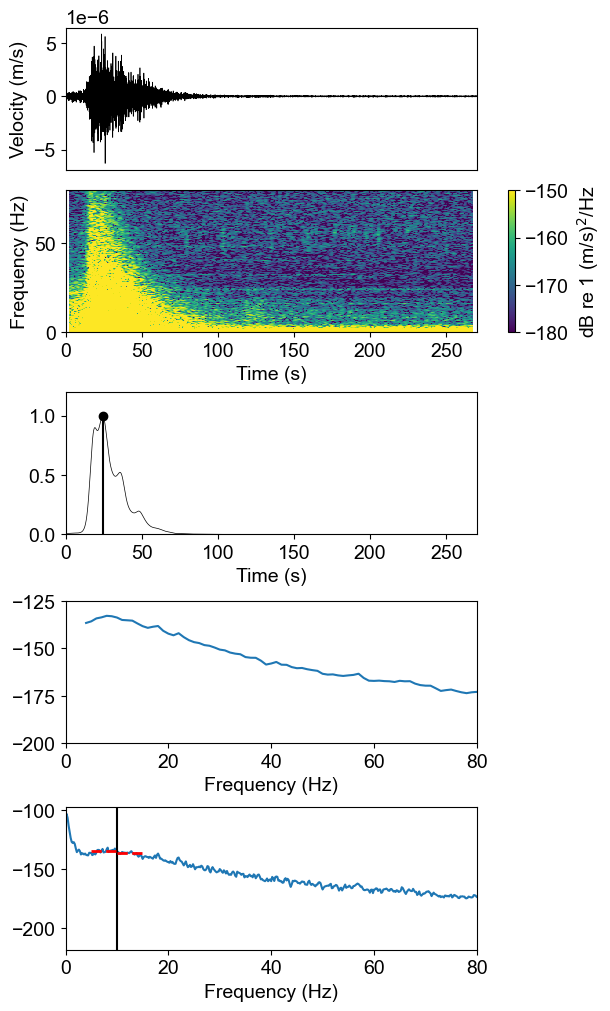

In [13]:
t1 = tphase_time[0]
t2 = tphase_time[1]

fig,ax = plt.subplots(5,figsize=[6,10],constrained_layout=True)

st1 = client.get_waveforms("OO",'HYSB1',"*","HHN",t1-5,t2+5,attach_response=True);
st1.resample(200).merge(fill_value='interpolate')
st1.filter('bandpass',freqmin=3,freqmax=10)
st1.remove_response();
st1.trim(starttime=t1,endtime=t2)
ax[0].plot(st1[0].data,'k',linewidth=0.5)
ax[0].set_xlim(0,len(st1[0].data))
ax[0].get_xaxis().set_ticks([])
ax[0].set_ylabel('Velocity (m/s)')

st2 = client.get_waveforms("OO",'HYSB1',"*","HHN",t1-5,t2+5,attach_response=True);
st2.remove_response()
st2.trim(starttime=t1,endtime=t2)
st2[0].spectrogram(axes=ax[1],wlen=5,dbscale=True)
ax[1].images[0].set_clim([-180,-150])
ax[1].set_ylim([0,80])
c = ax[1].images[0]
plt.colorbar(c,label='dB re 1 (m/s)$^2$/Hz')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')

smoothed_window = apply_gaussian(st1[0].data,200,gaussian_width=15)
window_max = np.max(smoothed_window) # normalize window by its maximum
smoothed_window = [i/window_max for i in smoothed_window]
peaks = scipy.signal.find_peaks(smoothed_window,prominence=.1)
# ax[2].plot(st1[0].data,'k',linewidth=0.5)
ax[2].plot(smoothed_window,'k',linewidth=0.5)
if len(peaks[0]) > 0:
    ax[2].stem(peaks[0],[smoothed_window[i] for i in peaks[0]],linefmt='k')
ax[2].set_xlim([0,len(smoothed_window)])
ax[2].set_ylim([0,1.2])
ax[2].set_xticks([0,10000,20000,30000,40000,50000],['0','50','100','150','200','250'])
ax[2].set_xlabel('Time (s)')

st2 = client.get_waveforms("OO",'HYSB1',"*","HHN",t1-5,t2+5,attach_response=True);
st2[0].data = st2[0].data / st2[0].stats.response.instrument_sensitivity.value # Convert to m/s
st2.trim(starttime=t1,endtime=t2)
f,Pxx_den,peak_ind,peak_details,median_power = pick_peaks_welch(st2[0],200,1,microseism_cutoff=True)
ax[3].plot(f,Pxx_den)
if len(peak_ind) > 0:
    for p in peak_ind:
        ax[3].stem(f[p],Pxx_den[p],linefmt='r',bottom=-200)
ax[3].set_xlabel('Frequency (Hz)')
ax[3].set_xlim([0,80])
ax[3].set_ylim([-200,-125])

st2 = client.get_waveforms("OO",'HYSB1',"*","HHN",t1-35,t2+35,attach_response=True);
st2[0].data = st2[0].data / st2[0].stats.response.instrument_sensitivity.value # Convert to m/s
st2.trim(starttime=t1-30,endtime=t2+30)
f,Pxx_den,peak_ind,peak_details,median_power = pick_peaks_welch(st2[0],200,5,microseism_cutoff=False)
normalized_power = Pxx_den
freq_ratio = 10**(np.median(normalized_power[25:50])/10)/10**(np.median(normalized_power[50:75])/10)
freq_ratio_welch=freq_ratio
low_median = np.median(normalized_power[25:50])
high_median = np.median(normalized_power[50:75])
ax[4].plot(f,normalized_power)
ax[4].axvline(10,color='k')
ax[4].plot([5,10],[low_median,low_median],'r--',linewidth=2)
ax[4].plot([10,15],[high_median,high_median],'r--',linewidth=2)
ax[4].set_xlim([0,80])
# ax[4].set_title('Freq ratio = ' + str(np.round(freq_ratio,2)))
ax[4].set_xlabel('Frequency (Hz)')

print(freq_ratio)


plt.show()

# fig.savefig("/Users/zoekrauss/ooi_tremor/tremor_figs/tphase_detection.eps", dpi = 400)

#### Ship noise on HYSB1

1.1187724885215389


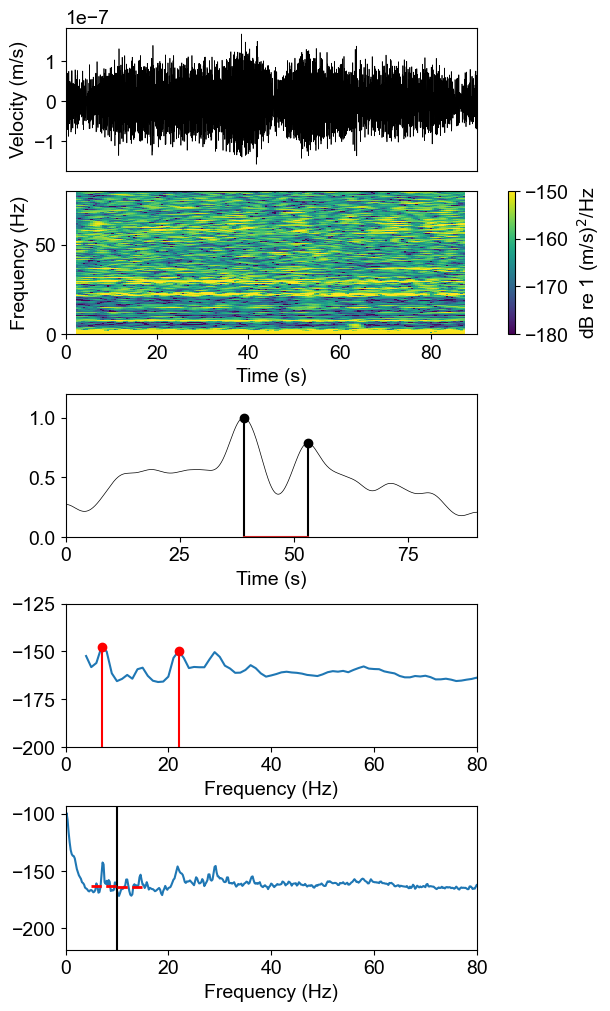

In [14]:
t1 = shipnoise_time[0]
t2 = shipnoise_time[1]

fig,ax = plt.subplots(5,figsize=[6,10],constrained_layout=True)

st1 = client.get_waveforms("OO",'HYSB1',"*","HHN",t1-5,t2+5,attach_response=True);
st1.resample(200).merge(fill_value='interpolate')
st1.filter('bandpass',freqmin=3,freqmax=10)
st1.remove_response();
st1.trim(starttime=t1,endtime=t2)
ax[0].plot(st1[0].data,'k',linewidth=0.5)
ax[0].set_xlim(0,len(st1[0].data))
ax[0].get_xaxis().set_ticks([])
ax[0].set_ylabel('Velocity (m/s)')

st2 = client.get_waveforms("OO",'HYSB1',"*","HHN",t1-5,t2+5,attach_response=True);
st2.remove_response()
st2.trim(starttime=t1,endtime=t2)
st2[0].spectrogram(axes=ax[1],wlen=5,dbscale=True)
ax[1].images[0].set_clim([-180,-150])
ax[1].set_ylim([0,80])
c = ax[1].images[0]
plt.colorbar(c,label='dB re 1 (m/s)$^2$/Hz')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')

smoothed_window = apply_gaussian(st1[0].data,200,gaussian_width=15)
window_max = np.max(smoothed_window) # normalize window by its maximum
smoothed_window = [i/window_max for i in smoothed_window]
peaks = scipy.signal.find_peaks(smoothed_window,prominence=.1)
ax[2].plot(smoothed_window,'k',linewidth=0.5)
if len(peaks[0]) > 0:
    ax[2].stem(peaks[0],[smoothed_window[i] for i in peaks[0]],linefmt='k')
ax[2].set_xlim([0,len(smoothed_window)])
ax[2].set_ylim([0,1.2])
ax[2].set_xticks([0,5000,10000,15000],['0','25','50','75'])
ax[2].set_xlabel('Time (s)')

st2 = client.get_waveforms("OO",'HYSB1',"*","HHN",t1-5,t2+5,attach_response=True);
st2[0].data = st2[0].data / st2[0].stats.response.instrument_sensitivity.value # Convert to m/s
st2.trim(starttime=t1,endtime=t2)

f,Pxx_den,peak_ind,peak_details,median_power = pick_peaks_welch(st2[0],200,1,microseism_cutoff=True)
# Pxx_den = [10*np.log10(d) for d in Pxx_den]
ax[3].plot(f,Pxx_den)
if len(peak_ind) > 0:
    for p in peak_ind:
        ax[3].stem(f[p],Pxx_den[p],linefmt='r',bottom=-200)
ax[3].set_xlabel('Frequency (Hz)')
ax[3].set_xlim([0,80])
ax[3].set_ylim([-200,-125])

st2 = client.get_waveforms("OO",'HYSB1',"*","HHN",t1-35,t2+35,attach_response=True);
st2[0].data = st2[0].data / st2[0].stats.response.instrument_sensitivity.value # Convert to m/s
st2.trim(starttime=t1-30,endtime=t2+30)
f,Pxx_den,peak_ind,peak_details,median_power = pick_peaks_welch(st2[0],200,5,microseism_cutoff=False)
# normalized_power = [s/np.max(Pxx_den) for s in Pxx_den]
normalized_power = Pxx_den
freq_ratio = 10**(np.median(normalized_power[25:50])/10)/10**(np.median(normalized_power[50:75])/10)
freq_ratio_welch=freq_ratio
low_median = np.median(normalized_power[25:50])
high_median = np.median(normalized_power[50:75])
ax[4].plot(f,normalized_power)
ax[4].axvline(10,color='k')
ax[4].plot([5,10],[low_median,low_median],'r--',linewidth=2)
ax[4].plot([10,15],[high_median,high_median],'r--',linewidth=2)
ax[4].set_xlim([0,80])
# ax[4].set_title('Freq ratio = ' + str(np.round(freq_ratio,2)))
ax[4].set_xlabel('Frequency (Hz)')

print(freq_ratio)


plt.show()

# fig.savefig("/Users/zoekrauss/ooi_tremor/tremor_figs/shipnoise_detection.eps", dpi = 400)

#### Tectonic tremor on Hikurangi station EBS3

In [16]:
tremor_time = [obspy.UTCDateTime('2014-10-08T07:38:33.184396Z'),obspy.UTCDateTime('2014-10-08T07:40:33.198287Z')]

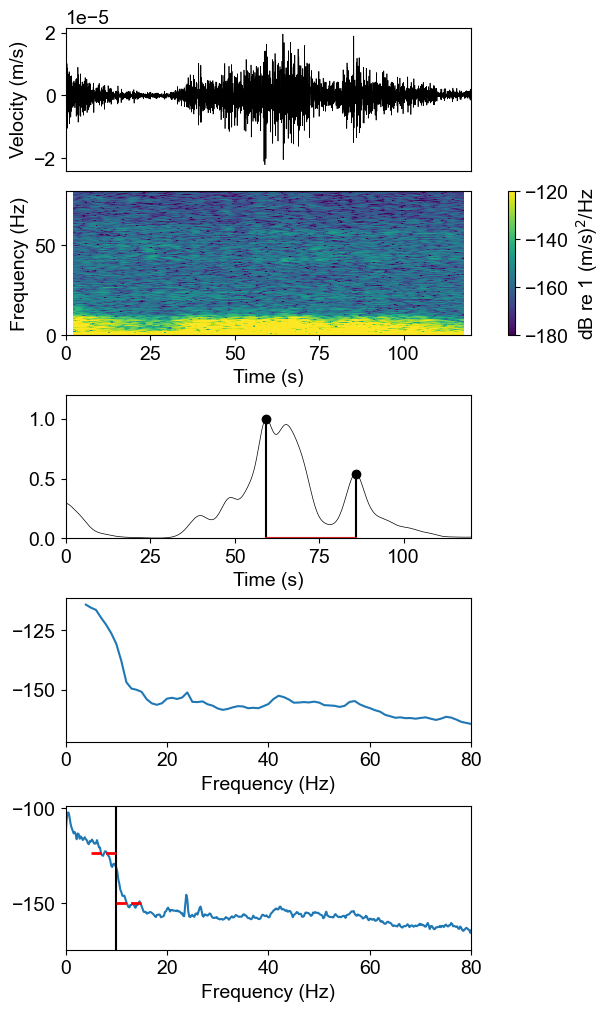

418.08983856033706


In [17]:
t1 = tremor_time[0]
t2 = tremor_time[1]

fig,ax = plt.subplots(5,figsize=[6,10],constrained_layout=True)

st1 = client.get_waveforms("YH","EBS3","*","EH1",t1-5,t2+5,attach_response=True);
st1.resample(200).merge(fill_value='interpolate')
st1.filter('bandpass',freqmin=3,freqmax=10)
st1.remove_response();
st1.trim(starttime=t1,endtime=t2)
ax[0].plot(st1[0].data,'k',linewidth=0.5)
ax[0].set_xlim(0,len(st1[0].data))
ax[0].get_xaxis().set_ticks([])
ax[0].set_ylabel('Velocity (m/s)')

st2 = client.get_waveforms("YH","EBS3","*","EH1",t1-5,t2+5,attach_response=True);
st2.remove_response()
st2.trim(starttime=t1,endtime=t2)
st2[0].spectrogram(axes=ax[1],wlen=5,dbscale=True)
ax[1].images[0].set_clim([-180,-120])
ax[1].set_ylim([0,80])
c = ax[1].images[0]
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
plt.colorbar(c,label='dB re 1 (m/s)$^2$/Hz')

smoothed_window = apply_gaussian(st1[0].data,200,gaussian_width=15)
window_max = np.max(smoothed_window) # normalize window by its maximum
smoothed_window = [i/window_max for i in smoothed_window]
peaks = scipy.signal.find_peaks(smoothed_window,prominence=.1)
ax[2].plot(smoothed_window,'k',linewidth=0.5)
if len(peaks[0]) > 0:
    ax[2].stem(peaks[0],[smoothed_window[i] for i in peaks[0]],linefmt='k')
ax[2].set_xlim([0,len(smoothed_window)])
ax[2].set_ylim([0,1.2])
ax[2].set_xticks([0,5000,10000,15000,20000],['0','25','50','75','100'])
ax[2].set_xlabel('Time (s)')

st2 = client.get_waveforms("YH","EBS3","*","EH1",t1-5,t2+5,attach_response=True);
st2[0].data = st2[0].data / st2[0].stats.response.instrument_sensitivity.value # Convert to m/s
st2.trim(starttime=t1,endtime=t2)
f,Pxx_den,peak_ind,peak_details,median_power = pick_peaks_welch(st2[0],200,1,microseism_cutoff=True)
ax[3].plot(f,Pxx_den)
if len(peak_ind) > 0:
    for p in peak_ind:
        ax[3].stem(f[p],Pxx_den[p],linefmt='r',bottom=-200)
ax[3].set_xlabel('Frequency (Hz)')
ax[3].set_xlim([0,80])

st2 = client.get_waveforms("YH","EBS3","*","EH1",t1-35,t2+35,attach_response=True);
st2[0].data = st2[0].data / st2[0].stats.response.instrument_sensitivity.value # Convert to m/s
st2.trim(starttime=t1-30,endtime=t2+30)
f,Pxx_den,peak_ind,peak_details,median_power = pick_peaks_welch(st2[0],200,5,microseism_cutoff=False)
normalized_power = Pxx_den
freq_ratio = 10**(np.median(normalized_power[25:50])/10)/10**(np.median(normalized_power[50:75])/10)
freq_ratio_welch=freq_ratio
low_median = np.median(normalized_power[25:50])
high_median = np.median(normalized_power[50:75])
ax[4].plot(f,normalized_power)
ax[4].axvline(10,color='k')
ax[4].plot([5,10],[low_median,low_median],'r--',linewidth=2)
ax[4].plot([10,15],[high_median,high_median],'r--',linewidth=2)
ax[4].set_xlim([0,80])
ax[4].set_xlabel('Frequency (Hz)')


plt.show()

print(freq_ratio)

# fig.savefig("/Users/zoekrauss/ooi_tremor/tremor_figs/tremor_detection.eps", dpi = 400)

## Classification functions below

In [6]:
def pick_peaks_welch(trace,sampling_rate,nperseg_multiple,microseism_cutoff=True):
    
    fs = sampling_rate
    x = trace.data
    nperseg = fs * nperseg_multiple
    
    f,Pxx_den = scipy.signal.welch(x,fs,nperseg=nperseg)
    if microseism_cutoff is True:
        f = f[4:]
        Pxx_den = Pxx_den[4:]
        
    Pxx_den = [10*np.log10(d) for d in Pxx_den]
    median_power = np.median(Pxx_den[20:80])
    
    peaks = scipy.signal.find_peaks(Pxx_den,threshold =median_power*5,prominence=10) 
    peak_ind = peaks[0]
    
    return(f,Pxx_den,peak_ind,peaks,median_power)

In [7]:
def apply_gaussian(filtered_data,samp_rate,gaussian_width=5):
    """
    Gaussian Width in seconds
    """
    
    # Square data
    data = filtered_data**2
    
    gaussian_radius = int((gaussian_width * samp_rate)/2)
    smoothed_window=scipy.ndimage.gaussian_filter1d(data,sigma=gaussian_radius/4,radius=gaussian_radius)
    
    return smoothed_window